In [12]:
"""
multiobjective_stratified_split.py
Prototype pipeline to split molecules into Train/Test satisfying:
  1) distribution similarity on numeric properties (Wasserstein per-column),
  2) low inter-set structural similarity (Tanimoto),
  3) high intra-set structural similarity (Tanimoto).
Method: cluster by structure (Butina), then greedy selection of clusters for Test
with multi-objective score. Increase restarts to improve solution.
"""

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import KBinsDiscretizer
import random
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import rdFingerprintGenerator


# -----------------------------
# Parameters (tuneable)
# -----------------------------
FP_RADIUS = 2
FP_NBITS = 2048
BUTINA_TANIMOTO_CUTOFF = 0.5
NUM_BINS = 12                     # for each numeric property histogram
TEST_FRACTION = 0.2
RESTARTS = 20
SIZE_PENALTY_WEIGHT = 0.2        # weight for size deviation term
LAMBDA_WASS = 1.0                # weight for distribution distance term
LAMBDA_INTER = 1.0               # weight for inter-similarity term
LAMBDA_INTRA = 1.5               # weight for intra-similarity term (added with minus sign in objective)
RANDOM_SEED = 1337

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# -----------------------------
# Utility: fingerprints, butina
# -----------------------------
def mol_from_smiles(smi):
    try:
        m = Chem.MolFromSmiles(str(smi).split()[0])  # strip trailing annotations if any
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def morgan_fp(smiles, radius=FP_RADIUS, nBits=FP_NBITS):
    m = mol_from_smiles(smiles)
    if m is None:
        return None
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    fp = gen.GetFingerprint(m)
    return fp

def cluster_butina_from_fps(fps, cutoff=BUTINA_TANIMOTO_CUTOFF):
    """Butina clustering: returns list of clusters (each is list of indices into fps)."""
    n = len(fps)
    if n == 0:
        return []
    # build upper-triangular distances list as Butina expects
    dists = []
    for i in range(1, n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1.0 - s for s in sims])
    clusters = Butina.ClusterData(dists, n, 1.0 - cutoff, isDistData=True)
    clusters = [list(c) for c in clusters]
    return clusters


# -----------------------------
# Cluster stats: histograms, medoid fp, weights
# -----------------------------
def compute_global_bin_edges(df, numeric_cols, num_bins=NUM_BINS):
    # Use quantile binning edges per column
    bin_edges = {}
    for col in numeric_cols:
        vals = df[col].dropna().values
        if len(vals) < 2:
            edges = np.linspace(0.0, 1.0, num_bins + 1)
        else:
            quantiles = np.linspace(0, 1, num_bins + 1)
            edges = np.quantile(vals, quantiles)
            # ensure strictly increasing edges (qcut duplicates may cause equality)
            # if duplicates, fallback to small jitter
            for i in range(1, len(edges)):
                if edges[i] <= edges[i-1]:
                    edges[i] = edges[i-1] + 1e-6
        bin_edges[col] = edges
    return bin_edges

def hist_from_values(vals, edges):
    if len(vals) == 0:
        return np.zeros(len(edges)-1)
    h, _ = np.histogram(vals, bins=edges)
    total = h.sum()
    if total > 0:
        return h.astype(float) / total
    else:
        return np.zeros_like(h, dtype=float)

def compute_cluster_info(df, clusters, numeric_cols, bin_edges):
    """
    clusters: list of lists of df indices
    returns:
      cluster_info: dict cid -> dict with keys:
        'indices', 'count', 'medoid_idx', 'medoid_fp', 'hists': {col:hist}, 'nonmissing_count':{col:count}
    """
    cluster_info = {}
    for cid, inds in enumerate(clusters):
        sub = df.iloc[inds]
        info = {}
        info['indices'] = inds
        info['count'] = len(inds)
        # medoid: find index with minimal sum distance to others (using fingerprints should be provided externally)
        # for now leave medoid_idx to be filled later after fp list known
        info['hists'] = {}
        info['nonmissing_count'] = {}
        for col in numeric_cols:
            colvals = sub[col].dropna().values
            info['nonmissing_count'][col] = len(colvals)
            info['hists'][col] = hist_from_values(colvals, bin_edges[col])
        cluster_info[cid] = info
    return cluster_info

# -----------------------------
# compute medoid fingerprints and cluster sim matrix
# -----------------------------
def compute_cluster_medoid_fps(clusters, fps_list):
    """
    fps_list: list of RDKit fingerprint objects aligned to original df indices
    clusters: list of lists of indices into fps_list
    returns: medoid_idx_per_cluster (original index), medoid_fp_per_cluster
    """
    medoid_idx = {}
    medoid_fp = {}
    for cid, inds in enumerate(clusters):
        if len(inds) == 0:
            medoid_idx[cid] = None
            medoid_fp[cid] = None
            continue
        # compute pairwise similarity matrix within cluster
        best_idx = None
        best_score = -1.0
        for i in inds:
            sims = []
            for j in inds:
                if i == j:
                    continue
                s = DataStructs.TanimotoSimilarity(fps_list[i], fps_list[j])
                sims.append(s)
            avg_sim = np.mean(sims) if len(sims) > 0 else 1.0
            if avg_sim > best_score:
                best_score = avg_sim
                best_idx = i
        medoid_idx[cid] = best_idx
        medoid_fp[cid] = fps_list[best_idx] if best_idx is not None else None
    return medoid_idx, medoid_fp

def compute_cluster_similarity_matrix(medoid_fp):
    """
    medoid_fp: dict cid->fingerprint
    returns matrix S where S[i,j] = Tanimoto(medoid_i, medoid_j)
    """
    cids = sorted(medoid_fp.keys())
    n = len(cids)
    S = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            fpi = medoid_fp[cids[i]]
            fpj = medoid_fp[cids[j]]
            if fpi is None or fpj is None:
                sim = 0.0
            else:
                sim = DataStructs.TanimotoSimilarity(fpi, fpj)
            S[i, j] = sim
            S[j, i] = sim
    return S


# -----------------------------
# Wasserstein distance utilities (1D) using CDF method or scipy
# -----------------------------
def wasserstein_1d_from_hist(p, q, bin_centers=None, bin_widths=None):
    """
    p, q: 1D numpy arrays (histograms, may sum to 1 or not)
    bin_centers: sequence length k (optional)
    bin_widths: sequence length k (optional) - width per bin used for weighting CDF difference
    returns W1 scalar
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    if p.sum() <= 0 and q.sum() <= 0:
        return 0.0
    if p.sum() <= 0:
        p = np.ones_like(p) / p.size
    else:
        p = p / p.sum()
    if q.sum() <= 0:
        q = np.ones_like(q) / q.size
    else:
        q = q / q.sum()
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    if bin_widths is None:
        widths = np.ones_like(p)
    else:
        widths = np.asarray(bin_widths, dtype=float)
    return float(np.sum(np.abs(cdf_p - cdf_q) * widths))


# -----------------------------
# similarity aggregation helpers (approximate via medoids and size weights)
# -----------------------------
def weighted_avg_pairwise_similarity(cluster_ids, S_matrix, cluster_info):
    """
    Approximate average pairwise similarity within a set of clusters,
    weighting by cluster sizes.
    cluster_ids: iterable of cluster ids
    S_matrix: cluster x cluster similarity matrix (medoid similarities)
    cluster_info: dict with 'count' for each cluster
    Returns scalar in [0,1]
    """
    ids = list(cluster_ids)
    if len(ids) == 0:
        return 0.0
    # weight by cluster sizes to approximate per-molecule pairs
    weights = np.array([cluster_info[c]['count'] for c in ids], dtype=float)
    total_pairs_weight = 0.0
    sim_sum = 0.0
    # approximate avg pairwise sim between molecules in clusters a and b as S[a,b]
    for i_idx, a in enumerate(ids):
        for j_idx, b in enumerate(ids):
            if i_idx > j_idx:
                continue
            if a == b:
                # within same cluster, approximate intra-cluster sim as  avg similarity of medoid to members
                # we'll approximate as 1.0 for same cluster (since cluster formed by similarity)
                sim = 1.0
            else:
                sim = S_matrix[a, b]
            # weight by product of sizes (unordered pairs)
            wa = cluster_info[a]['count']
            wb = cluster_info[b]['count']
            if a == b:
                pair_weight = wa * (wa - 1) / 2.0
            else:
                pair_weight = wa * wb
            sim_sum += sim * pair_weight
            total_pairs_weight += pair_weight
    if total_pairs_weight == 0:
        return 0.0
    return float(sim_sum / total_pairs_weight)


def weighted_avg_cross_similarity(cluster_ids_A, cluster_ids_B, S_matrix, cluster_info):
    """
    Approximate average similarity between clusters in set A and clusters in set B,
    weighting by cluster sizes => approximate per-molecule cross-set average
    """
    A = list(cluster_ids_A)
    B = list(cluster_ids_B)
    if len(A) == 0 or len(B) == 0:
        return 0.0
    sim_sum = 0.0
    total_weight = 0.0
    for a in A:
        for b in B:
            sim = S_matrix[a, b]
            wa = cluster_info[a]['count']
            wb = cluster_info[b]['count']
            sim_sum += sim * wa * wb
            total_weight += wa * wb
    if total_weight == 0:
        return 0.0
    return float(sim_sum / total_weight)


def wavg_pairwise_similarity(fps):
    sims = []
    for i in range(1,len(fps)):
        sim = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        sims.extend(sim)
    return np.mean(sims)

def wavg_cross_similarity(fps_A, fps_B):
    sims = []
    for a in fps_A:
        for b in fps_B:
            sim = DataStructs.TanimotoSimilarity(a, b)
            sims.append(sim)
    return np.mean(sims)

# -----------------------------
# greedy selection of test clusters (multi-objective)
# -----------------------------
def greedy_select_clusters_multiobj(cluster_info, global_hists, bin_centers_dict,
                                    S_matrix, test_fraction=TEST_FRACTION,
                                    restarts=RESTARTS,
                                    lambda_wass=LAMBDA_WASS,
                                    lambda_inter=LAMBDA_INTER,
                                    lambda_intra=LAMBDA_INTRA,
                                    size_penalty_weight=SIZE_PENALTY_WEIGHT):
    """
    Returns best_selection = (selected_cluster_ids, sel_count, score, metrics_dict)
    metrics_dict includes Wasserstein, intersim, intra_train, intra_test
    """
    cluster_ids = list(cluster_info.keys())
    total_n = sum(cluster_info[c]['count'] for c in cluster_ids)
    target_n = int(round(test_fraction * total_n))
    max_cluster_size = max(cluster_info[c]['count'] for c in cluster_ids)
    best = None
    best_score = float('inf')

    # Precompute per-cluster weighted hist numerators and denominators per column for fast aggregation
    # num_i[col] = cluster_info[i]['hists'][col] * nonmissing_count
    num_i = {cid: {} for cid in cluster_ids}
    den_i = {cid: {} for cid in cluster_ids}
    for cid in cluster_ids:
        for col, hist in cluster_info[cid]['hists'].items():
            w = cluster_info[cid]['nonmissing_count'][col]
            num_i[cid][col] = hist * w
            den_i[cid][col] = w

    # helper to compute aggregated hist of a set of cluster ids
    def aggregate_hist_for_set(selected):
        agg = {}
        denom = {}
        for col in global_hists.keys():
            agg[col] = np.zeros_like(global_hists[col], dtype=float)
            denom[col] = 0.0
        for cid in selected:
            for col in global_hists.keys():
                agg[col] += num_i[cid][col]
                denom[col] += den_i[cid][col]
        # normalized vectors (if denom>0)
        for col in global_hists.keys():
            if denom[col] > 0:
                agg[col] = agg[col] / denom[col]
            else:
                agg[col] = np.zeros_like(agg[col])
        return agg, denom

    # compute baseline global hist centers (for wasserstein bin centers)
    # here we set bin centers to middle points from global_hists object: caller must supply bin_centers_dict
    # start restarts
    for r in range(restarts):
        order = cluster_ids.copy()
        random.shuffle(order)
        selected = []
        sel_count = 0
        # incremental aggregates
        agg_num = {col: np.zeros_like(global_hists[col]) for col in global_hists.keys()}
        agg_den = {col: 0.0 for col in global_hists.keys()}

        # greedy loop: add cluster that most reduces objective (approx using only Wasserstein part + size constraint),
        # we will compute full objective when candidate chosen
        improved = True
        while improved and sel_count < target_n:
            improved = False
            best_local = None
            best_local_obj = float('inf')
            # evaluate each candidate not yet selected
            for cid in order:
                if cid in selected:
                    continue
                new_sel_count = sel_count + cluster_info[cid]['count']
                # avoid huge overshoot
                if new_sel_count > target_n + max_cluster_size:
                    continue
                # compute candidate aggregated hist quickly
                local_agg = {}
                for col in global_hists.keys():
                    new_num = agg_num[col] + num_i[cid][col]
                    new_den = agg_den[col] + den_i[cid][col]
                    if new_den > 0:
                        p_new = new_num / new_den
                    else:
                        p_new = np.zeros_like(global_hists[col])
                    local_agg[col] = p_new
                # Wasserstein sum over cols
                wass = 0.0
                for col in global_hists.keys():
                    centers = bin_centers_dict[col]
                    wass += wasserstein_1d_from_hist(local_agg[col], global_hists[col], bin_centers=centers)
                # partial score: only wass for local ranking
                if wass < best_local_obj:
                    best_local_obj = wass
                    best_local = cid
            if best_local is not None:
                # accept add
                selected.append(best_local)
                sel_count += cluster_info[best_local]['count']
                # update agg_num/den
                for col in global_hists.keys():
                    agg_num[col] += num_i[best_local][col]
                    agg_den[col] += den_i[best_local][col]
                improved = True
            else:
                break

        # if not reaching target, fill with smallest clusters
        if sel_count < target_n:
            remaining = [c for c in order if c not in selected]
            remaining.sort(key=lambda x: cluster_info[x]['count'])
            for cid in remaining:
                if sel_count >= target_n:
                    break
                selected.append(cid)
                sel_count += cluster_info[cid]['count']
                for col in global_hists.keys():
                    agg_num[col] += num_i[cid][col]
                    agg_den[col] += den_i[cid][col]

        # now compute full objective for this selected set
        # aggregated p for test
        agg_test = {col: (agg_num[col] / agg_den[col] if agg_den[col] > 0 else np.zeros_like(agg_num[col])) for col in global_hists.keys()}
        # Wasserstein distance between aggregated test and global
        wass_total = 0.0
        for col in global_hists.keys():
            wass_total += wasserstein_1d_from_hist(agg_test[col], global_hists[col], bin_centers=bin_centers_dict[col])

        # compute inter-sim and intra-sim approximations using medoid similarity matrix
        test_set = set(selected)
        train_set = set(cluster_ids) - test_set
        inter_sim = weighted_avg_cross_similarity(test_set, train_set, S_matrix, cluster_info)
        intra_test = weighted_avg_pairwise_similarity(test_set, S_matrix, cluster_info)
        intra_train = weighted_avg_pairwise_similarity(train_set, S_matrix, cluster_info)
        
        # build final score (we minimize)
        size_penalty = abs(sel_count - target_n) / max(1, target_n)
        score = lambda_wass * wass_total + lambda_inter * inter_sim - lambda_intra * (intra_train + intra_test) + size_penalty_weight * size_penalty

        if score < best_score:
            best_score = score
            best = (selected.copy(), sel_count, score, {
                'wass': wass_total,
                'inter_sim': inter_sim,
                'intra_test': intra_test,
                'intra_train': intra_train,
                'size_penalty': size_penalty
            })

    return best, best_score


# -----------------------------
# Wrap up: run pipeline on DataFrame
# -----------------------------
def run_split_pipeline(df, numeric_cols=['HLM','KSOL','LogD','MDR1-MDCKII','MLM'],
                       test_fraction=TEST_FRACTION, num_bins=NUM_BINS,
                       butina_cutoff=BUTINA_TANIMOTO_CUTOFF):
    # 1. compute fingerprints (list aligned to df index)
    fps = []
    valid_idx = []
    for i, s in enumerate(df['smiles'].astype(str).tolist()):
        fp = morgan_fp(s)
        if fp is None:
            print(f"Warning: invalid SMILES at idx {i}, will skip!")
            continue
        fps.append(fp)
        valid_idx.append(i)
    # if some SMILES invalid, filter df
    if len(valid_idx) != len(df):
        df_valid = df.iloc[valid_idx].reset_index(drop=True)
    else:
        df_valid = df.reset_index(drop=True)

    # 2. clustering
    clusters_rel = cluster_butina_from_fps(fps, cutoff=butina_cutoff)  # indices relative to fps list (and valid_idx)
    # convert to df indices
    clusters_mapped = []
    for cl in clusters_rel:
        clusters_mapped.append([valid_idx[i] for i in cl])

    # 3. compute global bin edges & histograms
    bin_edges = compute_global_bin_edges(df_valid, numeric_cols, num_bins=num_bins)
    global_hists = {}
    # global hist per col
    for col in numeric_cols:
        vals = df_valid[col].dropna().values
        global_hists[col] = hist_from_values(vals, bin_edges[col])

    # 4. compute cluster_info
    cluster_info = compute_cluster_info(df_valid, clusters_mapped, numeric_cols, bin_edges)

    # 5. compute medoid fps and similarity matrix (note medoid fp indices are in original df index space)
    medoid_idx, medoid_fp = compute_cluster_medoid_fps(clusters_mapped, fps_list=fps)  # careful: fps_list uses valid_idx mapping
    # But our compute_cluster_medoid_fps expects fps indexed by original df positions; we passed fps_list=fps which lines up with valid_idx order
    # So medoid_idx entries are original df index positions in valid_idx space; we will reindex medoid mapping to cluster ids
    # To simplify integration, rebuild medoid_fp_per_cluster list indexed by cluster id order
    medoid_fp_per_cid = {}
    for cid in range(len(clusters_mapped)):
        # find medoid index in fps list: medoid_idx[cid] is original df index in valid_idx mapping
        med = medoid_idx[cid]
        if med is None:
            medoid_fp_per_cid[cid] = None
        else:
            # med is index in original df: find its position in valid_idx to get fps position
            # In our compute_cluster_medoid_fps we used fps list indices (0..len(fps)-1) so med points directly
            medoid_fp_per_cid[cid] = medoid_fp[cid]

    S_matrix = compute_cluster_similarity_matrix(medoid_fp_per_cid)

    # 6. build bin centers (for wasserstein) as midpoints of edges
    bin_centers = {}
    bin_widths = {}
    for col, edges in bin_edges.items():
        centers = 0.5 * (edges[:-1] + edges[1:])
        widths = edges[1:] - edges[:-1]
        bin_centers[col] = centers
        bin_widths[col] = widths

    # 7. run greedy selection
    best, best_score = greedy_select_clusters_multiobj(
        cluster_info=cluster_info,
        global_hists=global_hists,
        bin_centers_dict=bin_centers,
        S_matrix=S_matrix,
        test_fraction=test_fraction,
        restarts=RESTARTS,
        lambda_wass=LAMBDA_WASS,
        lambda_inter=LAMBDA_INTER,
        lambda_intra=LAMBDA_INTRA,
        size_penalty_weight=SIZE_PENALTY_WEIGHT
    )

    if best is None:
        raise RuntimeError("No selection found. Try adjusting parameters or check clusters.")

    selected_cids, sel_count, score_val, metrics = best
    print("Selected clusters:", selected_cids)
    print("Test molecules:", sel_count, "score:", score_val)
    print("Metrics:", metrics)

    # Build final assignment over df_valid indices
    assign = np.array(['Train'] * len(df_valid))
    for cid in selected_cids:
        for idx in cluster_info[cid]['indices']:
            # idx is original df_valid index
            assign[idx] = 'Test'
    df_valid['Set_split'] = assign
    # If original df had rows filtered, we can map back to original size; here we return df_valid
    return df_valid, clusters_mapped, cluster_info, bin_edges, global_hists, S_matrix, metrics


# -----------------------------
# Diagnostics plotting helpers
# -----------------------------
def plot_property_distribution(df_with_split, col='LogD', set_col='Set_split'):
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_with_split, x=col, hue=set_col, bins=30, stat='density', common_norm=False, kde=True, alpha=0.4)
    plt.title(f"{col} distribution: Train vs Test")
    plt.tight_layout()
    plt.show()

def plot_similarity_diagnostics(df_with_split, smiles_col='smiles', set_col='Set_split'):
    # compute fps
    train_smiles = df_with_split[df_with_split[set_col] == 'Train'][smiles_col].tolist()
    test_smiles  = df_with_split[df_with_split[set_col] == 'Test'][smiles_col].tolist()
    train_fps = [morgan_fp(s) for s in train_smiles]
    test_fps  = [morgan_fp(s) for s in test_smiles]
    # intra train
    tr_sims = []
    for i in range(len(train_fps)):
        for j in range(i+1, len(train_fps)):
            tr_sims.append(DataStructs.TanimotoSimilarity(train_fps[i], train_fps[j]))
    te_sims = []
    for i in range(len(test_fps)):
        for j in range(i+1, len(test_fps)):
            te_sims.append(DataStructs.TanimotoSimilarity(test_fps[i], test_fps[j]))
    cross_sims = []
    for a in train_fps:
        for b in test_fps:
            cross_sims.append(DataStructs.TanimotoSimilarity(a, b))
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    sns.histplot(tr_sims, bins=30, kde=True); plt.title("Intra-train sims")
    plt.subplot(1,3,2)
    sns.histplot(te_sims, bins=30, kde=True); plt.title("Intra-test sims")
    plt.subplot(1,3,3)
    sns.histplot(cross_sims, bins=30, kde=True); plt.title("Train-Test cross sims")
    plt.tight_layout()
    plt.show()




In [13]:
df_train = pd.read_csv("dataset/raw/train_polaris.csv")
df_test = pd.read_csv("dataset/raw/test_polaris.csv")
smils_train = df_train['smiles'].tolist()
smils_test = df_test['SMILES'].tolist()
fps_train =  [morgan_fp(s) for s in smils_train]
fps_test =  [morgan_fp(s) for s in smils_test]
sim_train =  wavg_pairwise_similarity(fps_train)
sim_test =  wavg_pairwise_similarity(fps_test)
sim_inter =  wavg_cross_similarity(fps_train, fps_test)

print(f"Intra similarity of trainset: {sim_train} ")
print(f"Intra similarity of testset: {sim_test} ")
print(f"Inter similarity of trainset and testset: {sim_inter} ")

Intra similarity of trainset: 0.1617900302727934 
Intra similarity of testset: 0.3575614711026197 
Inter similarity of trainset and testset: 0.1754696223572489 


In [14]:
Y_MAP = {"MLM":1, "HLM":2, "KSOL":3, "LogD":4, "MDR1-MDCKII":5}
Y_MAP = {v:k for k,v in Y_MAP.items()}
Y_MAP

{1: 'MLM', 2: 'HLM', 3: 'KSOL', 4: 'LogD', 5: 'MDR1-MDCKII'}

In [2]:

df = pd.read_csv("dataset/raw/train_polaris.csv")  # your DataFrame with CXSMILES and numeric cols
# df = pd.read_csv("dataset/zinc/raw/zinc.csv")
df_valid, clusters, cluster_info, bin_edges, global_hists, S_matrix, metrics = run_split_pipeline(df)


Selected clusters: [50, 23, 22, 59, 61, 62, 60, 82, 84, 17, 1, 6]
Test molecules: 98 score: 3.554147484913012
Metrics: {'wass': 4.450835194864291, 'inter_sim': 0.15641049920089076, 'intra_test': 0.5254572785000765, 'intra_train': 0.1934664318159291, 'size_penalty': 0.12643678160919541}


In [3]:
print(f"cluster_info: {cluster_info}")
print(f"bin_edges:{bin_edges}")
print(f"global_hists:{global_hists}")

cluster_info: {0: {'indices': [301, 242, 243, 244, 245, 246, 248, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 285, 287, 288, 289, 290, 307, 308, 309, 313, 318, 319, 320, 321, 322, 324, 327, 329, 350, 352, 353, 355, 406, 407, 412, 413, 417, 421], 'count': 63, 'hists': {'HLM': array([0.0952381 , 0.04761905, 0.03174603, 0.04761905, 0.0952381 ,
       0.0952381 , 0.12698413, 0.14285714, 0.06349206, 0.0952381 ,
       0.11111111, 0.04761905]), 'KSOL': array([0.        , 0.        , 0.        , 0.        , 0.02325581,
       0.        , 0.        , 0.02325581, 0.11627907, 0.27906977,
       0.23255814, 0.3255814 ]), 'LogD': array([0.03174603, 0.07936508, 0.12698413, 0.19047619, 0.28571429,
       0.17460317, 0.07936508, 0.01587302, 0.        , 0.01587302,
       0.        , 0.        ]), 'MDR1-MDCKII': array([0.06349206, 0.07936508, 0.04761905, 0.12698413, 0.07936508,
       0.06349206, 0.079

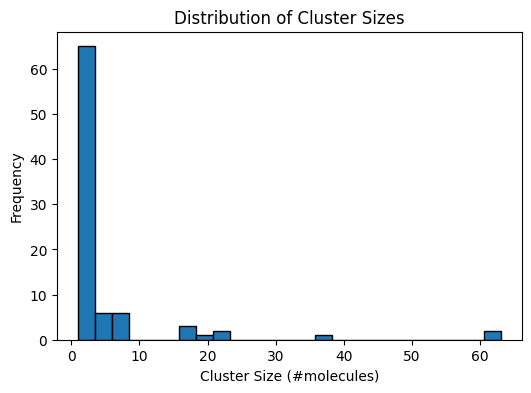

In [4]:
import matplotlib.pyplot as plt


cluster_sizes = [len(v) for v in clusters]
plt.figure(figsize=(6,4))
plt.hist(cluster_sizes, bins=25, edgecolor="k")
plt.xlabel("Cluster Size (#molecules)")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Sizes")
plt.show()

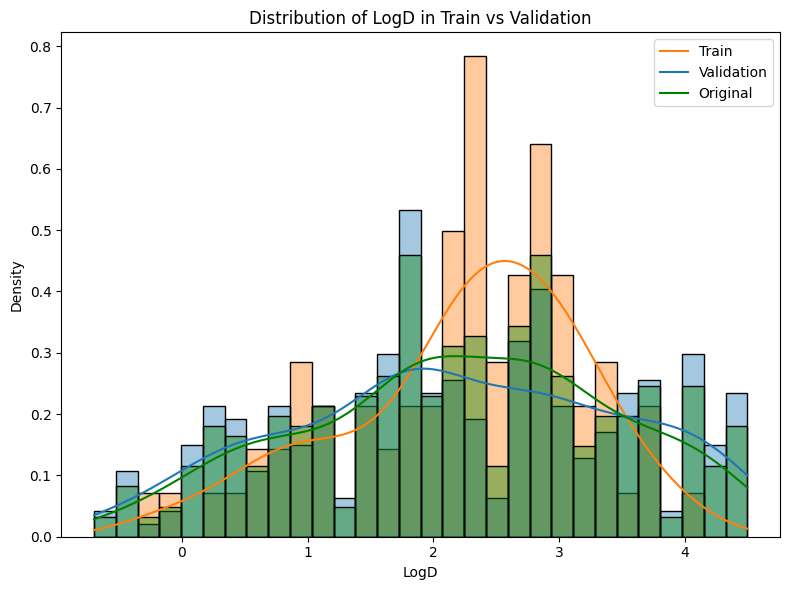

In [5]:
import seaborn as sns

def plot_logD_distribution(df,df1, col="LogD", set_col="Set_split"):
    plt.figure(figsize=(8,6))
    
    # histogram + kde
    sns.histplot(data=df, x=col, hue=set_col, bins=30, stat="density", common_norm=False, kde=True, alpha=0.4)
    sns.histplot(data=df1, x=col, color="green", bins=30, stat="density", common_norm=False, kde=True, alpha=0.4)
    plt.xlabel("LogD")
    plt.ylabel("Density")
    plt.title("Distribution of LogD in Train vs Validation")
    plt.legend(labels=["Train", "Validation",'Original'])

    plt.tight_layout()
    plt.show()

plot_logD_distribution(df_valid, df, col="LogD", set_col="Set_split")

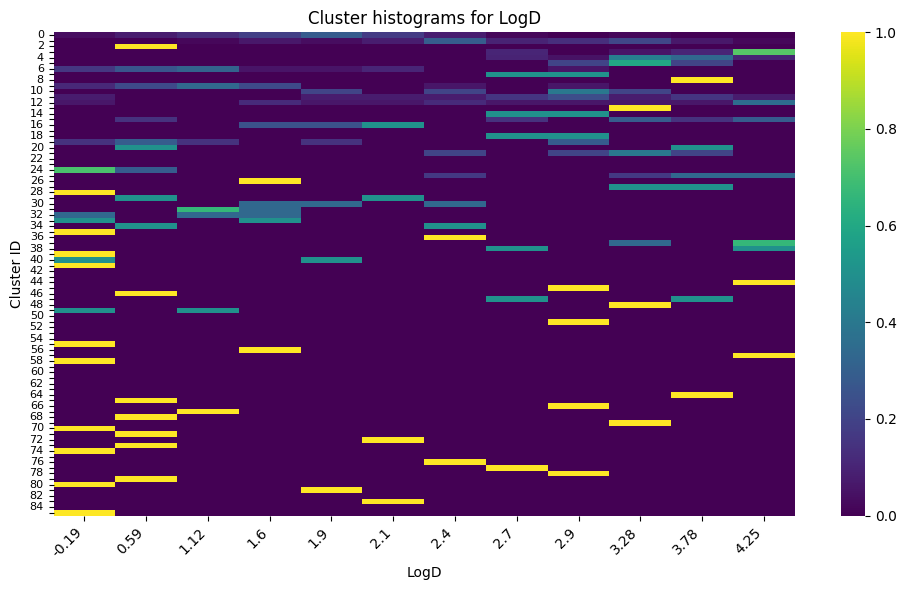

In [53]:
def plot_cluster_heatmap(cluster_info, col, bin_edges, max_labels=30):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    bins = bin_edges[col]
    centers = 0.5*(bins[:-1] + bins[1:])

    # build matrix
    cluster_ids = sorted(cluster_info.keys())
    data = [cluster_info[cid]["hists"][col] for cid in cluster_ids]
    data = np.array(data)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data, cmap="viridis", xticklabels=np.round(centers,2), yticklabels=cluster_ids)

    # only show a subset of y labels if too many
    if len(cluster_ids) > max_labels:
        step = len(cluster_ids) // max_labels
        for idx, label in enumerate(ax.get_yticklabels()):
            if idx % step != 0:
                label.set_visible(False)

    plt.xlabel(col)
    plt.ylabel("Cluster ID")
    plt.title(f"Cluster histograms for {col}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

plot_cluster_heatmap(cluster_info, col="LogD", bin_edges=bin_edges)